In [1]:
# write a teacher layer for test
# model2: teacher layer
# model3: not add xtrain in teacher layer
# model4: another student layer
import os
import pyro
import torch
import pickle

import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import pyro.distributions as dist

from torch import Tensor
from tqdm.auto import trange
from pyro.nn import PyroModule, PyroSample, PyroParam
from pyro.infer import MCMC, NUTS, SVI, Trace_ELBO, Predictive
from pyro.distributions import constraints
from pyro.infer.autoguide import AutoDiagonalNormal

os.chdir("../../")

from src.dgp_rff.outer_layer import SingleGP, SingleCauchyGP

In [2]:
import torch
torch.cuda.is_available()
# trouble shoot see this link:https://stackoverflow.com/questions/77068908/how-to-install-pytorch-with-cuda-support-on-windows-11-cuda-12-no-matching

True

In [3]:
torch.cuda.current_device()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)
# cuda = torch.device('cuda') 

  # Next step

0. Get familiar with the coding structure
1. CPU -> GPU
2. Last step without bias
3. Figure out how they train
4. How to access the posterior mean and std/scale from the model
5. Learn pickle: numpy.ndarray, png
6. ....
7. construct a DeepGP class

In [4]:
# Set random seed for reproducibility
np.random.seed(42)

# Read data
cwd = os.getcwd()
print(cwd)

X_train_path = os.path.join(cwd, "folds", "synthetic_DGP_fold_1_X_train.txt")
X_test_path = os.path.join(cwd, "folds", "synthetic_DGP_fold_1_X_test.txt")
Y_train_path = os.path.join(cwd, "folds", "synthetic_DGP_fold_1_Y_train.txt")
Y_test_path = os.path.join(cwd, "folds", "synthetic_DGP_fold_1_Y_test.txt")

x_obs = np.loadtxt(X_train_path)
y_obs = np.loadtxt(Y_train_path)
x_val = np.loadtxt(X_test_path)
y_val = np.loadtxt(Y_test_path)

# Set plot limits and labels
xlims = [-0.2, 0.2]

# The X and Y have to be at least 2-dim
x_train = torch.from_numpy(x_obs).float().reshape(-1,1)
y_train = torch.from_numpy(y_obs).float()
x_test = torch.from_numpy(x_val).float().reshape(-1,1)
y_test = torch.from_numpy(y_val).float()

C:\Users\yuanq\OneDrive\Desktopold\SB\research\DGPII\program\DGP-RFF-main


In [5]:
x_train = x_train.cuda()


In [6]:
y_train = y_train.cuda()
x_test = x_test.cuda()
y_test = y_test.cuda()

In [7]:
x_train.shape

torch.Size([10000, 1])

In [8]:
y_train.shape

torch.Size([10000, 3])

In [9]:
class Model(PyroModule):
    def __init__(self, in_dim=1, out_dim=1, J=50):
        super().__init__()
        
        self.out_dim = out_dim
        self.model = SingleGP(in_dim, out_dim, J)
        self.model.to('cuda')

    def forward(self, x, y=None):
        mu = self.model(x).squeeze() #10000*6
        
        # batch shape | event shapt
        # 10000       |
        
        scale = pyro.sample("sigma", dist.Gamma(torch.tensor(0.5, device='cuda'), torch.tensor(1.0, device='cuda'))).expand(self.out_dim)  # Infer the response noise

        # Sampling model
        with pyro.plate("data", x.shape[0]): # x.shape[0]=10000
            # obs = xxx("obs", mu, obs=y)
            obs = pyro.sample("obs", dist.MultivariateNormal(mu.cuda(), torch.diag(scale * scale).cuda()), obs=y)
            
#         f1: phi(Omega x)W (+ epsilon1)
#         f2: phi(Omega f1)W (+ epsilon2)
        
#         f2 + epsilon ~ N(0, Sigma)
            
        return mu

In [10]:
model = Model(in_dim=x_train.shape[1], out_dim=y_train.shape[1], J=50)
model = model.to('cuda')

In [11]:
model4 = Model(in_dim=x_train.shape[1], out_dim=y_train.shape[1], J=30)
model4 = model4.to('cuda')

In [12]:
mean_field_guide = AutoDiagonalNormal(model)
optimizer = pyro.optim.Adam({"lr": 0.001})

svi = SVI(model, mean_field_guide, optimizer, loss=Trace_ELBO())
pyro.clear_param_store()

num_epochs = 15000
progress_bar = trange(num_epochs)
l = 500
losslist = []

interval = max(num_epochs//l, 1)

for epoch in progress_bar:
    loss = svi.step(x_train, y_train)
    if epoch % interval == 0:
        losslist.append(loss/ x_train.shape[0])
    progress_bar.set_postfix(loss=f"{loss / x_train.shape[0]:.3f}")

  0%|          | 0/15000 [00:00<?, ?it/s]

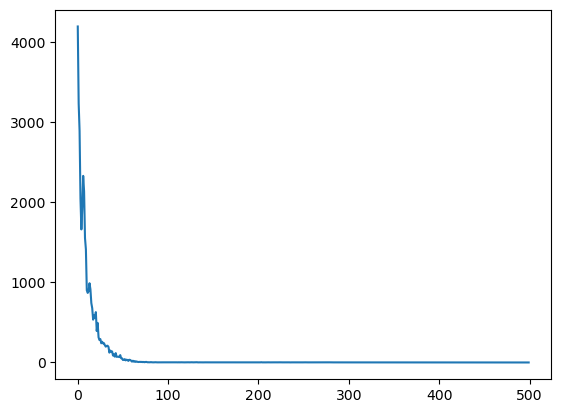

In [13]:
plt.plot(losslist)

In [14]:
model.parameters()

<generator object Module.parameters at 0x000001D68BA2E260>

In [15]:
predictive1 = Predictive(model, guide=mean_field_guide, num_samples=500)
preds1 = predictive1(x_test)

In [16]:
y_pred1 = preds1['obs'].cpu().detach().numpy().mean(axis=0)

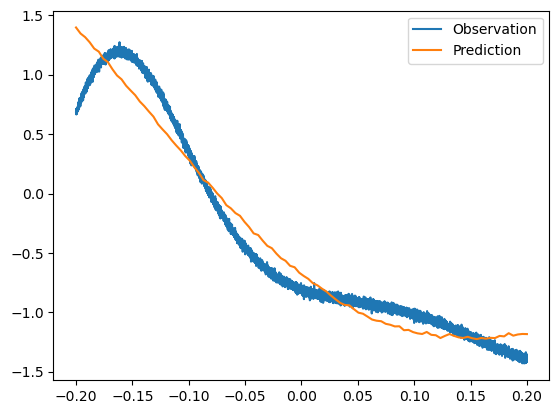

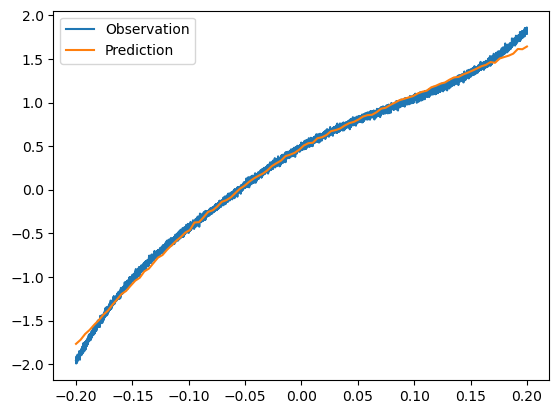

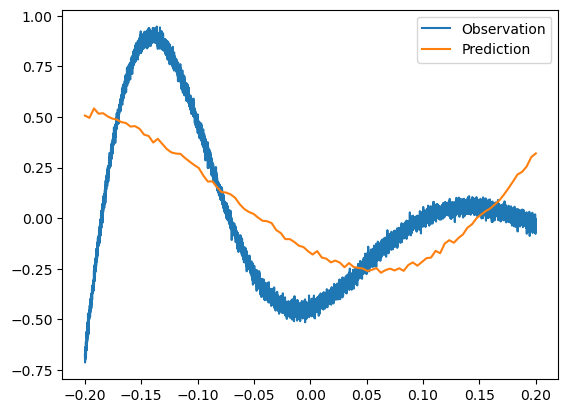

In [26]:
for d in range(3):
    plt.plot(x_obs, y_obs[:,d], label="Observation")
    plt.plot(x_test.cpu(), y_pred1[:,d], label="Prediction")
    plt.legend()
    plt.show()

In [17]:
preds_output1 = predictive1(x_train)
y_1_putput_torch = preds_output1['obs'].mean(axis=0)
print(y_1_putput_torch.shape)
y_1_output = preds_output1['obs'].cpu().detach().numpy().mean(axis=0)

torch.Size([10000, 3])


In [52]:
mean_field_guide = AutoDiagonalNormal(model4)
optimizer = pyro.optim.Adam({"lr": 0.001})

svi = SVI(model4, mean_field_guide, optimizer, loss=Trace_ELBO())
pyro.clear_param_store()

num_epochs = 15000
progress_bar = trange(num_epochs)
l = 500
losslist4 = []

interval = max(num_epochs//l, 1)

for epoch in progress_bar:
    loss = svi.step(x_train, y_train)
    if epoch % interval == 0:
        losslist4.append(loss/ x_train.shape[0])
    progress_bar.set_postfix(loss=f"{loss / x_train.shape[0]:.3f}")

  0%|          | 0/15000 [00:00<?, ?it/s]

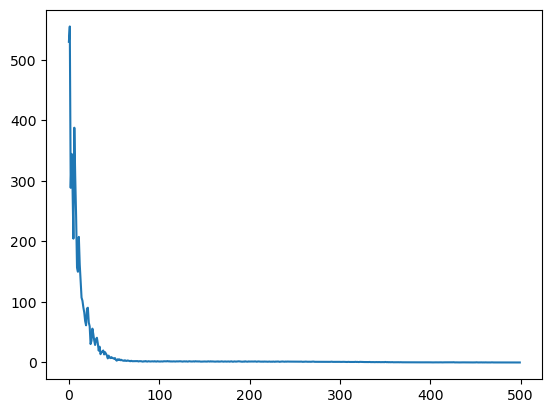

In [53]:
plt.plot(losslist4)

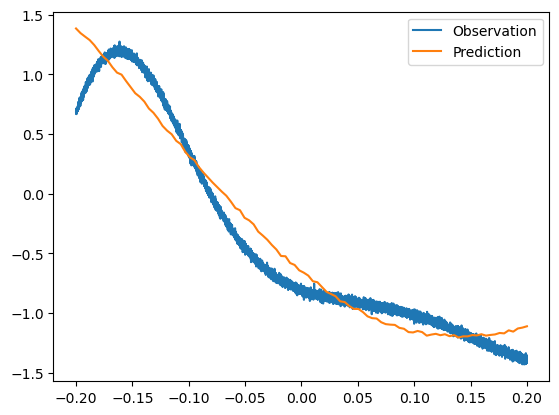

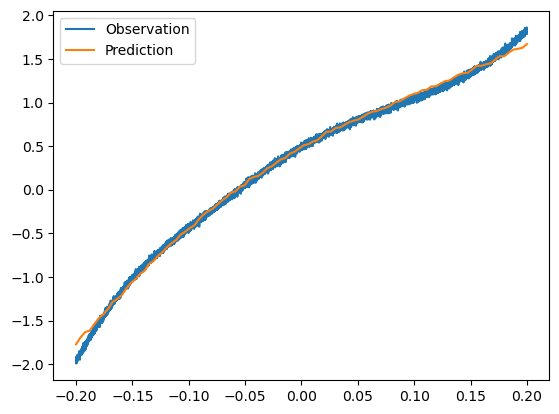

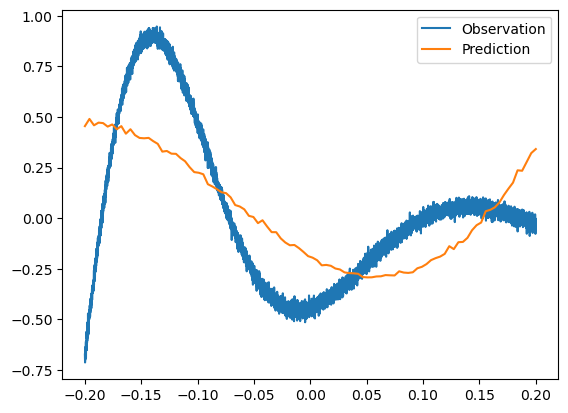

In [54]:
predictive4 = Predictive(model4, guide=mean_field_guide, num_samples=500)
preds4 = predictive4(x_test)

In [55]:
y_pred4 = preds4['obs'].cpu().detach().numpy().mean(axis=0)

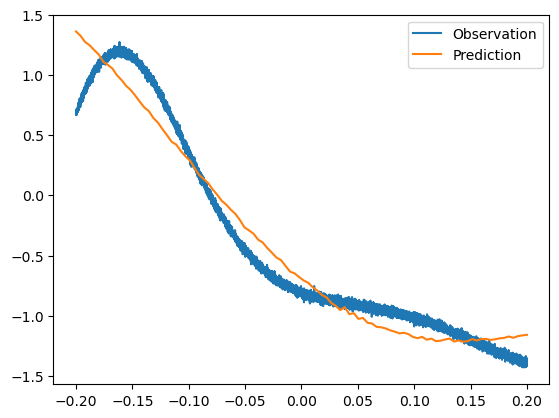

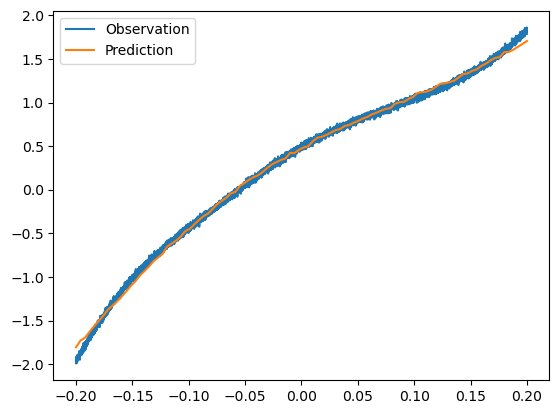

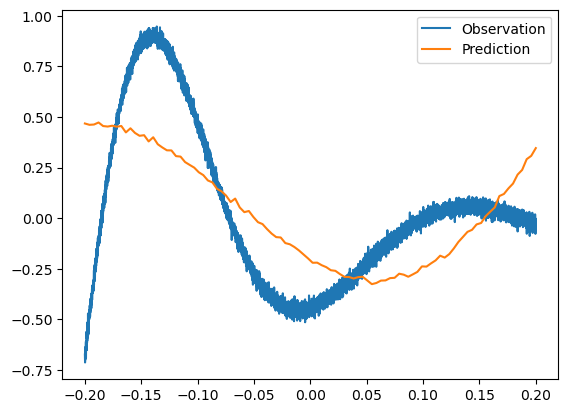

In [56]:
for d in range(3):
    plt.plot(x_obs, y_obs[:,d], label="Observation")
    plt.plot(x_test.cpu(), y_pred4[:,d], label="Prediction")
    plt.legend()
    plt.show()

In [57]:
preds_output4 = predictive4(x_train)#from the 2nd student GP
y_4_output_torch = preds_output4['obs'].mean(axis=0)
print(y_4_output_torch.shape)
y_4_output = preds_output4['obs'].cpu().detach().numpy().mean(axis=0)

torch.Size([10000, 3])


In [27]:
y_pred1_torch = torch.from_numpy(y_pred1).cuda()
x_test_2 = torch.cat((x_test, y_pred1_torch), dim=1)
print(x_test_2.shape)

torch.Size([100, 4])


In [28]:
x_train_2 = torch.cat((x_train,y_1_putput_torch),dim=1)

print(x_train_2.shape)

torch.Size([10000, 4])


In [ ]:
#x_test_2 = torch.cat((x_test,y_1_test_output),dim=1)

In [29]:
model2 = Model(in_dim=x_train_2.shape[1], out_dim=y_train.shape[1], J=50)
model2 = model2.to('cuda')

In [30]:
model3 = Model(in_dim=y_1_output.shape[1], out_dim=y_train.shape[1], J=50)
model3 = model3.to('cuda')

In [31]:
mean_field_guide = AutoDiagonalNormal(model2)
optimizer = pyro.optim.Adam({"lr": 0.001})

svi = SVI(model2, mean_field_guide, optimizer, loss=Trace_ELBO())
pyro.clear_param_store()

num_epochs = 15000
progress_bar = trange(num_epochs)
l = 500
losslist2 = []

interval = max(num_epochs//l, 1)
for epoch in progress_bar:
    loss = svi.step(x_train_2, y_train)
    if epoch % interval == 0:
        losslist2.append(loss/ x_train.shape[0])
    progress_bar.set_postfix(loss=f"{loss / x_train.shape[0]:.3f}")

  0%|          | 0/15000 [00:00<?, ?it/s]

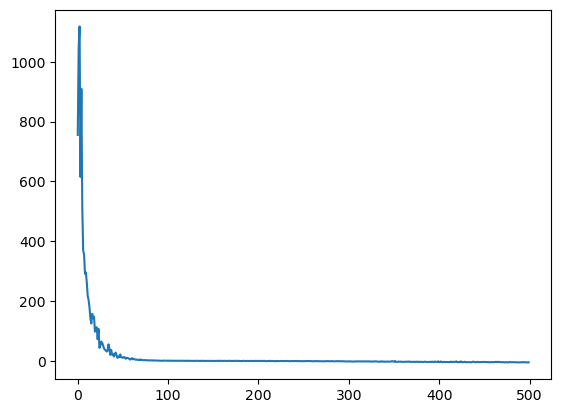

In [32]:
plt.plot(losslist2)

In [33]:
predictive2 = Predictive(model2, guide=mean_field_guide, num_samples=500)
preds2= predictive2(x_test_2)
y_pred2 = preds2['obs'].cpu().detach().numpy().mean(axis=0)

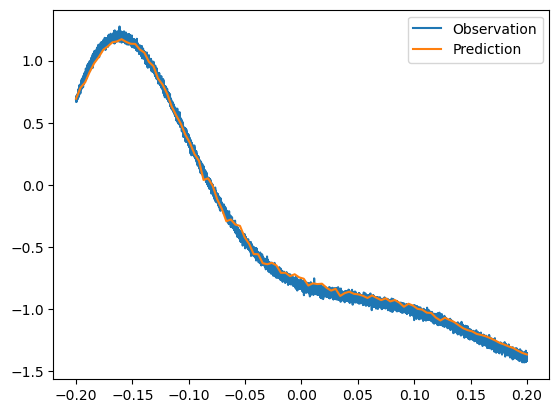

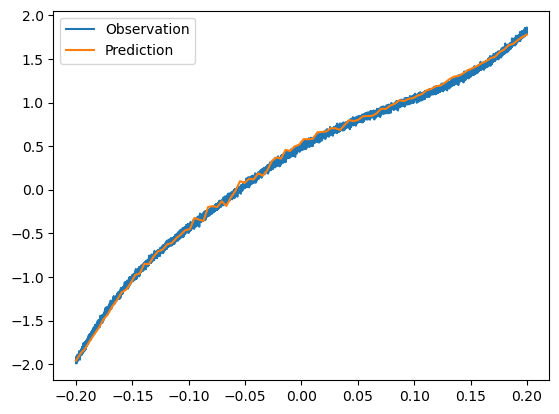

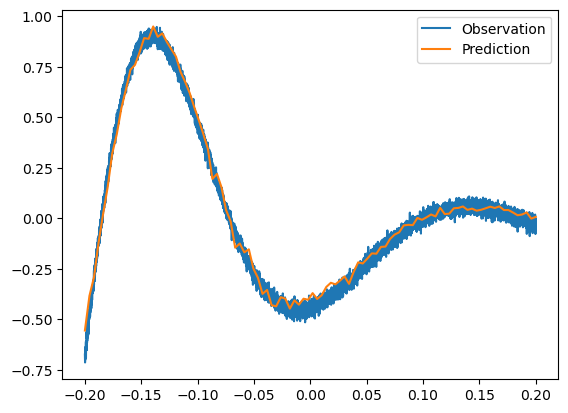

In [34]:
for d in range(3):
    plt.plot(x_obs, y_obs[:,d], label="Observation")
    plt.plot(x_test.cpu(), y_pred2[:,d], label="Prediction")
    plt.legend()
    plt.show()

In [35]:
mean_field_guide = AutoDiagonalNormal(model3)
optimizer = pyro.optim.Adam({"lr": 0.001})

svi = SVI(model3, mean_field_guide, optimizer, loss=Trace_ELBO())
pyro.clear_param_store()

num_epochs = 15000
progress_bar = trange(num_epochs)
l = 500
losslist3 = []

interval = max(num_epochs//l, 1)
for epoch in progress_bar:
    loss = svi.step(y_1_putput_torch, y_train)
    if epoch % interval == 0:
        losslist3.append(loss/ x_train.shape[0])
    progress_bar.set_postfix(loss=f"{loss / x_train.shape[0]:.3f}")

  0%|          | 0/15000 [00:00<?, ?it/s]

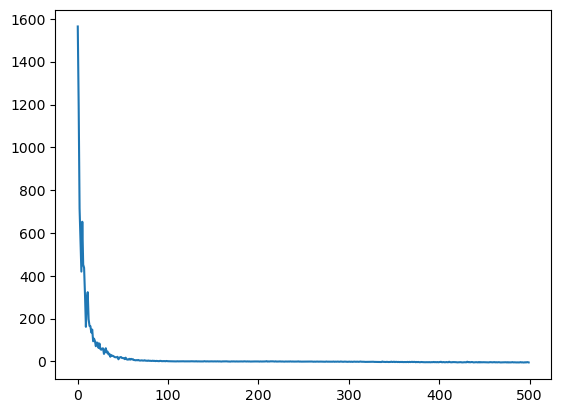

In [36]:
plt.plot(losslist3)

In [37]:
predictive3 = Predictive(model3, guide=mean_field_guide, num_samples=500)
preds3= predictive3(y_pred1_torch)
y_pred3 = preds3['obs'].cpu().detach().numpy().mean(axis=0)


In [38]:
print(y_pred3.shape)

(100, 3)


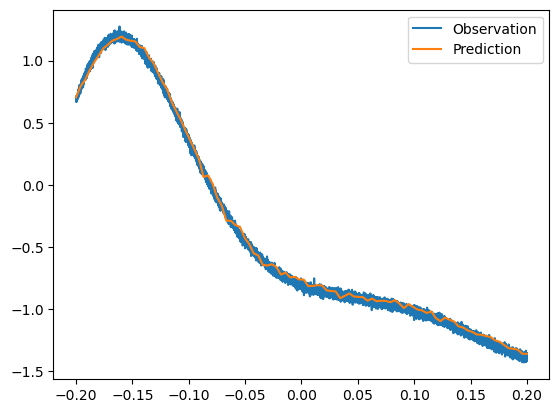

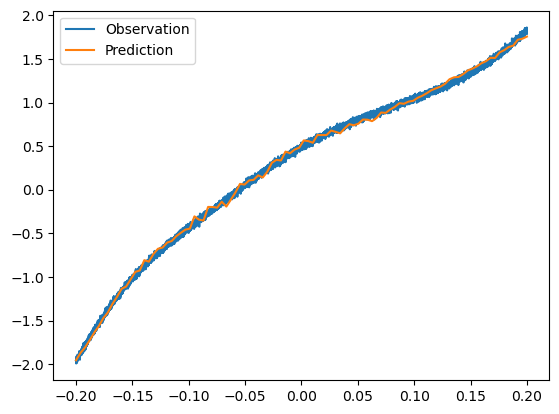

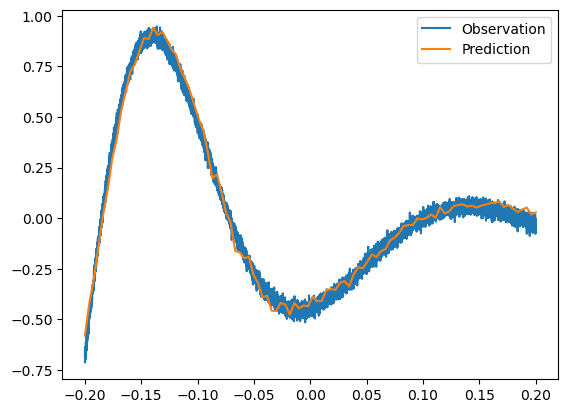

In [39]:
for d in range(3):
    plt.plot(x_obs, y_obs[:,d], label="Observation")
    plt.plot(x_test.cpu(), y_pred3[:,d], label="Prediction")
    plt.legend()
    plt.show()

In [41]:
x_train_5 = torch.cat((x_train,y_1_putput_torch,y_4_putput_torch),dim=1)

print(x_train_5.shape)

torch.Size([10000, 7])


In [42]:
model5 = Model(in_dim=x_train_5.shape[1], out_dim=y_train.shape[1], J=50)
model5 = model5.to('cuda')

In [43]:
mean_field_guide = AutoDiagonalNormal(model5)
optimizer = pyro.optim.Adam({"lr": 0.001})

svi = SVI(model5, mean_field_guide, optimizer, loss=Trace_ELBO())
pyro.clear_param_store()

num_epochs = 15000
progress_bar = trange(num_epochs)
l = 500
losslist5 = []

interval = max(num_epochs//l, 1)
for epoch in progress_bar:
    loss = svi.step(x_train_5, y_train)
    if epoch % interval == 0:
        losslist5.append(loss/ x_train.shape[0])
    progress_bar.set_postfix(loss=f"{loss / x_train.shape[0]:.3f}")

  0%|          | 0/15000 [00:00<?, ?it/s]

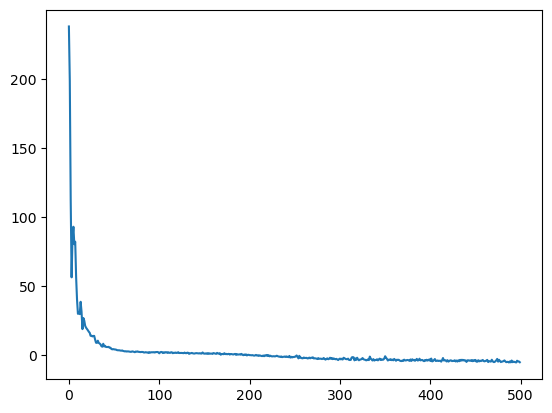

In [44]:
plt.plot(losslist5)

In [45]:
y_pred4_torch = torch.from_numpy(y_pred4).cuda()
x_test_5 = torch.cat((x_test,y_pred1_torch,y_pred4_torch),dim=1)
print(x_test_5.shape)

torch.Size([100, 7])


In [60]:
predictive5 = Predictive(model5, guide=mean_field_guide, num_samples=500)
preds5= predictive5(x_test_5)
y_pred5 = preds5['obs'].cpu().detach().numpy().mean(axis=0)
#这样的cell为什么不能重新run

RuntimeError: mat1 and mat2 shapes cannot be multiplied (100x7 and 1x30)
                   Trace Shapes:       
                    Param Sites:       
                   Sample Sites:       
model.layers.0.layer.weight dist | 50 7
                           value | 30 1

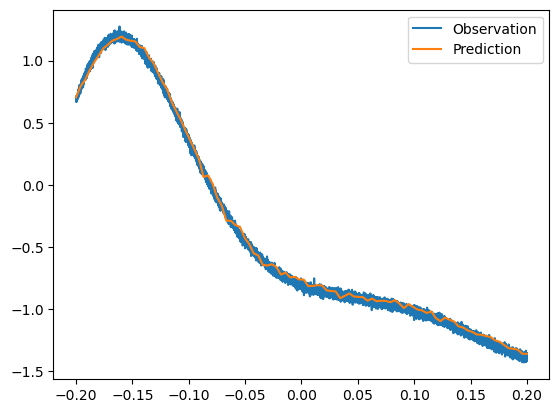

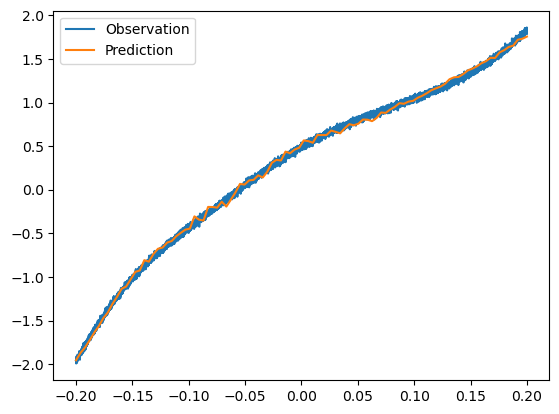

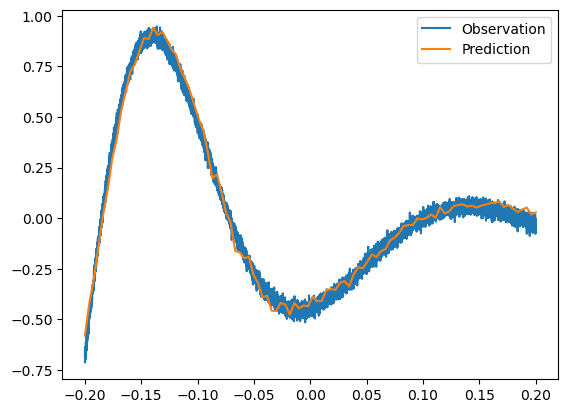

In [48]:
for d in range(3):
    plt.plot(x_obs, y_obs[:,d], label="Observation")
    plt.plot(x_test.cpu(), y_pred5[:,d], label="Prediction")
    plt.legend()
    plt.show()

In [ ]:
# sampled Omega: model.model.layers[0].layer.weight

In [ ]:
# preds['model.layers.0.layer.weight'].squeeze().mean(axis=0): Omega estimator

In [ ]:
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name).shape)

1 -> 50; 100 -> 6

Omega 1*50  1*50
W     6*100 6*100
bias  6     6
sigma 1     1

In [ ]:
# def model(data):
#   alpha = torch.tensor(6.0)
#   beta = torch.tensor(10.0)
#   pay_probs = pyro.sample('pay_probs', dist.Beta(alpha, beta).expand(3).independent(1))
#   normalized_pay_probs = pay_probs / torch.sum(pay_probs)

#   with pyro.iarange('data_loop', len(data)):
#     pyro.sample('obs', dist.Categorical(probs=normalized_pay_probs), obs=data)

In [ ]:
# def guide(data):
#   alphas = pyro.param('alphas', torch.tensor(6.).expand(3), constraint=constraints.positive)
#   betas = pyro.param('betas', torch.tensor(10.).expand(3), constraint=constraints.positive) 

#   pyro.sample('pay_probs', dist.Beta(alphas, betas).independent(1))